In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 /root/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras import Sequential
import matplotlib.pyplot as plt
import cv2 # for images

In [ ]:
conv_base = VGG16(
    include_top=False, # this means that I am not importing the flatten and Dense layers
    weights = 'imagenet',
    input_shape = (150,150,3)
)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# to don't train the VGG16 models convolution layer again we use this code
# this is basically a freezing part
conv_base.trainable = False


In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(units = 232,activation = 'relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units = 332,activation = 'relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units = 1,activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_24 (Dense)            (None, 232)               1900776   
                                                                 
 batch_normalization_9 (Batc  (None, 232)              928       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 232)               0         
                                                                 
 dense_25 (Dense)            (None, 332)               77356     
                                                     

## To train our model in batches we use generators

In [ ]:
# generator for our dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# to convert above files values range between 0-1 
def process(image,label):
    image = tf.cast(image/256. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
history = model.fit(train_ds,epochs=10,validation_data=validation_ds,batch_size = 32)

Epoch 1/10
625/625 [==============================] - 57s 86ms/step - loss: 0.4555 - accuracy: 0.8720 - val_loss: 0.4078 - val_accuracy: 0.8936
Epoch 2/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4193 - accuracy: 0.8770 - val_loss: 0.4224 - val_accuracy: 0.8612
Epoch 3/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4236 - accuracy: 0.8748 - val_loss: 0.8675 - val_accuracy: 0.7172
Epoch 4/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4345 - accuracy: 0.8705 - val_loss: 0.7965 - val_accuracy: 0.7090
Epoch 5/10
625/625 [==============================] - 63s 101ms/step - loss: 0.4232 - accuracy: 0.8717 - val_loss: 0.4134 - val_accuracy: 0.8486
Epoch 6/10
625/625 [==============================] - 54s 86ms/step - loss: 0.4199 - accuracy: 0.8730 - val_loss: 0.4142 - val_accuracy: 0.8658
Epoch 7/10
625/625 [==============================] - 64s 101ms/step - loss: 0.4039 - accuracy: 0.8758 - val_loss: 0.3671 - val_accurac

Text(0.5, 1.0, 'val_loss- 0.681 and loss- 0.408')

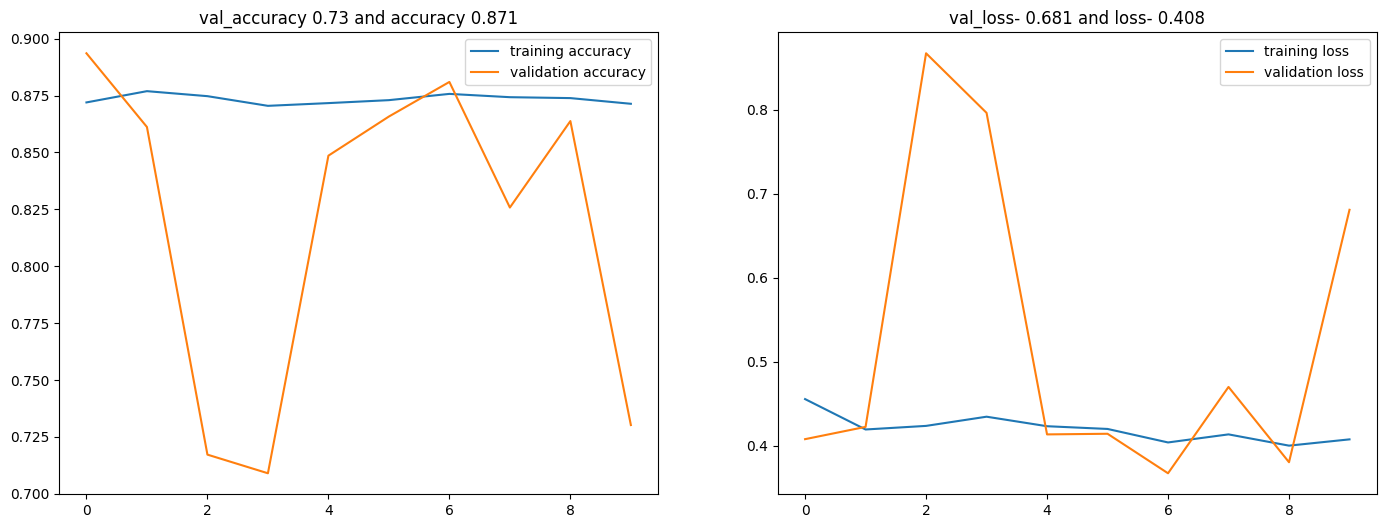

In [ ]:
plt.subplots(nrows=1,ncols=2,figsize = (17,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][9],ndigits=3)} and accuracy {round(history.history["accuracy"][9],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][9],ndigits=3)} and loss- {round(history.history["loss"][9],ndigits=3)}')